In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from numpy.random import multivariate_normal as mvnorm
from numpy.linalg import norm

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
%matplotlib inline

import pdb, time

seed = 0
np.random.seed(seed)

### Import and generate data

In [2]:
# Import data
data = pd.read_pickle("~/Downloads/integrated_draws_20_5_4.pkl")
n_draws, n_time, dim_X, dim_fac = data['beta'].shape
beta = data['beta']
X_sd = data['x_sd']

# Generate X
m_fac = np.zeros((dim_fac))
s_fac = np.diag(np.ones((dim_fac)))
fac = np.expand_dims(mvnorm(m_fac, s_fac, (n_draws, n_time)), -1)

X = np.matmul(beta, fac).squeeze()

m_eps = np.zeros((dim_X))
for i in range(n_draws):
    eps = mvnorm(m_eps, np.diag(X_sd[i] ** 2), n_time)
    X[i] += X[i] + eps
    
X = X.transpose((2, 0, 1))
X_cov = np.einsum('ijkl,jmkl->imkl', np.expand_dims(X, 1), np.expand_dims(X, 0))

In [3]:
n_dimensions, _, n_samples, time_steps = X_cov.shape
emp_inv = []
for i in range(time_steps):
    emp_inv.append(np.linalg.inv(np.mean(X_cov[:, :, :, i], 2)))
emp_inv = np.array(emp_inv)

### Train

In [4]:
weights=[None]
max_iter = 1000
# weights=['lin', 200]

In [ ]:
from regain.covariance import TaylorEqualTimeGraphicalLasso, TimeGraphicalLasso
tic = time.perf_counter()
tgl_tpe = TaylorEqualTimeGraphicalLasso(max_iter=max_iter, loss='LL', c_level=0.2, theta=0.5, rho=1e2, mult=1.1, weights=weights, m=50, eps=2, psi="laplacian")
emp_inv_score_tpe, baseline_score_tpe, fit_score_tpe, pre_tpe = tgl_tpe.fit_cov(X_cov).eval_cov_pre() 
toc = time.perf_counter()
print('Running Time :{}'.format(toc - tic))
# min_pre_tp = np.amin(np.abs(pre_tp[pre_tp != 0]))

0
-8.740402676266871 -9.29709750442249
1370.1205366781583


/Users/sky/.pyenv/versions/3.7.4/lib/python3.7/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


100
0.00010757007681405639 9.45559424366138e-06
383.96640393240926
200
3.4806850074176054e-05 4.416844010606269e-06
230.51082703438246
300
2.2454267458726918e-05 4.436252718491573e-06
153.911088786451


/Users/sky/.pyenv/versions/3.7.4/lib/python3.7/site-packages/scipy/optimize/optimize.py:2216: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


400
3.115452354052195e-05 4.5360819130735305e-06
107.18159673452564


In [6]:
from regain.covariance import GradientEqualTimeGraphicalLasso, TimeGraphicalLasso
tic = time.perf_counter()
tgl_g = GradientEqualTimeGraphicalLasso(max_iter=max_iter, loss='LL', c_level=0.2, theta=0.5, rho=1e2, mult=1.1, weights=weights, m=50, eps=2, psi="laplacian")
emp_inv_score_g, baseline_score_g, fit_score_g, pre_g = tgl_g.fit_cov(X_cov).eval_cov_pre() 
toc = time.perf_counter()
print('Running Time :{}'.format(toc - tic))
# min_pre_tp = np.amin(np.abs(pre_tp[pre_tp != 0]))

/Users/sky/.pyenv/versions/3.7.4/lib/python3.7/site-packages/scipy/optimize/optimize.py:2217: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)


0
0.0008981529615823547 -0.0898707108169539
1331.5303752778445
100
0.002483127485135128 0.0015662774930127199
290.13081648636904
200
0.0024917278120284436 0.0015638132130622751
152.69608626474027
300
0.002449238836888412 0.0015276376378407974
89.1922402522061
400
0.0023337067962359015 0.0015054029794794844
53.372975048156256
500
0.0023079832803034606 0.0014430994914562945
31.65309166873123
600
0.00235533668811172 0.0013555973148077526
19.540942289177423
700
0.0024195967714106814 0.0012133375797518653
14.03060397124048
800
0.0025059668805482715 0.0011614518482623737
11.959599514356807
900
0.00254873946263956 0.0011359241563151557
11.208924240692063
999 10.882403523484282
1.9757961957783884e-05 0.033182855080966356
0.48865779392140996 0.02837699692964874
Running Time :209.97065739799996


/Users/sky/Downloads/Booth/post_sum/regain/regain/covariance/gradient_equal_time_graphical_lasso.py:466: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


In [7]:
from regain.covariance import CVXInequalityTimeGraphicalLasso, TimeGraphicalLasso
pre_cvx = np.load("mosek_sol.npy")

In [8]:
from regain.norm import l1_od_norm
from regain.validation import check_norm_prox
psi, prox_psi, psi_node_penalty = check_norm_prox(tgl_g.psi)

def penalty_objective(Z_0, Z_1, Z_2, psi, theta):
    """Penalty-only objective function for time-varying graphical LASSO."""
    return theta * sum(map(l1_od_norm, Z_0)) + (1 - theta) * sum(map(psi, Z_2 - Z_1))

pre = {}
fit_score = {}
for i in [1e-4, 1e-6, 0]:
    pre[i] = np.array([k * (np.abs(k) >= i) for k in pre_cvx])
    tgl_g.precision_ = pre[i]
    emp_inv_score, baseline_score, fit_score[i], _ = tgl_g.eval_cov_pre() 
    print(penalty_objective(pre[i], pre[i][:-1], pre[i][1:], psi, tgl_g.theta))

pre_tpe_thres = {}
fit_score_tpe_thres = {}
for i in [1e-4, 1e-6, 0]:
    pre_tpe_thres[i] = np.array([k * (np.abs(k) >= i) for k in pre_tpe])
    tgl_tpe.precision_ = pre_tpe_thres[i]
    emp_inv_score, baseline_score, fit_score_tpe_thres[i], _ = tgl_tpe.eval_cov_pre() 
    print(penalty_objective(pre_tpe_thres[i], pre_tpe_thres[i][:-1], pre_tpe_thres[i][1:], psi, tgl_tpe.theta))

pre_g_thres = {}
fit_score_g_thres = {}
for i in [1e-4, 1e-6, 0]:
    pre_g_thres[i] = np.array([k * (np.abs(k) >= i) for k in pre_g])
    tgl_g.precision_ = pre_g_thres[i]
    emp_inv_score, baseline_score, fit_score_g_thres[i], _ = tgl_g.eval_cov_pre() 
    print(penalty_objective(pre_g_thres[i], pre_g_thres[i][:-1], pre_g_thres[i][1:], psi, tgl_g.theta))

31.241989467266876
31.275525853691807
31.275533315173337
15.566443513846648
15.566720200830725
15.566720200830725
10.882163904019333
10.882403523484282
10.882403523484282


In [9]:
tgl = TimeGraphicalLasso(alpha=1., beta=1., mode='admm', rho=1, tol=1e-4,
            rtol=1e-4, psi='laplacian', max_iter=3000, verbose=False, assume_centered=False, 
            return_history=False, update_rho_options=None, compute_objective=True, 
            stop_at=None, stop_when=1e-4, suppress_warn_list=False, init='empirical')
fit_score_, pre_ = tgl.fit_cov(X_cov).eval_cov_pre()   

pre_thres = {}
fit_score_thres = {}
for i in [1e-4, 1e-6, 0]:
    pre_thres[i] = np.array([k * (np.abs(k) >= i) for k in pre_])
    tgl_g.precision_ = pre_thres[i]
    emp_inv_score, baseline_score, fit_score_thres[i], _ = tgl_g.eval_cov_pre() 
    print(penalty_objective(pre_thres[i], pre_thres[i][:-1], pre_thres[i][1:], psi, tgl_g.theta))

94 130.87757600445832
130.87753836700597
130.87757600445832
130.87757600445832


In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgb"
color_index = 0
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

ax.plot(range(len(tgl_tpe.obj)), tgl_tpe.obj, alpha=0.5, color='b',
        label=r'Lin')
ax.plot(range(len(tgl_g.obj)), tgl_g.obj, alpha=0.5, color='g',
        label=r'Grad')

fig.legend(fontsize=20, loc='upper right', bbox_to_anchor=(0.49, 0.44, 0.5, 0.5))
ax.set_ylabel('Objective', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Iteration', fontsize=25)
ax.set_title(r'Objective for Constrained ADMM', fontsize=30)
plt.tight_layout()
plt.savefig('syn_'+ str(weights[0]).lower() + '_' + str(max_iter) + '_obj.pdf')

In [10]:
# drop diagonals
t, p, _ = pre_cvx.shape
idx = np.where(~np.eye(p, dtype=bool))
pre_cvx_no_diag = np.array([pre_cvx[i][idx] for i in np.arange(t)])
pre_tpe_no_diag = np.array([pre_tpe[i][idx] for i in np.arange(t)])
pre_g_no_diag = np.array([pre_g[i][idx] for i in np.arange(t)])


log_abs_pre_cvx_no_diag = np.log10(np.abs(pre_cvx_no_diag[pre_cvx_no_diag != 0]))
log_abs_pre_tpe_no_diag = np.log10(np.abs(pre_tpe_no_diag[pre_tpe_no_diag != 0]))
log_abs_pre_g_no_diag = np.log10(np.abs(pre_g_no_diag[pre_g_no_diag != 0]))

print(np.max(np.abs(pre_cvx_no_diag)))
print(np.max(np.abs(pre_tpe_no_diag)))
print(np.max(np.abs(pre_g_no_diag)))

print(np.sum(np.abs(pre_cvx_no_diag) >= 0))

print(np.sum(log_abs_pre_cvx_no_diag >= -4))
print(np.sum(log_abs_pre_tpe_no_diag >= -4))
print(np.sum(log_abs_pre_g_no_diag >= -4))

0.05102680118485462
0.14500769424379695
0.06638150516554747
38000
14480
1190
1070


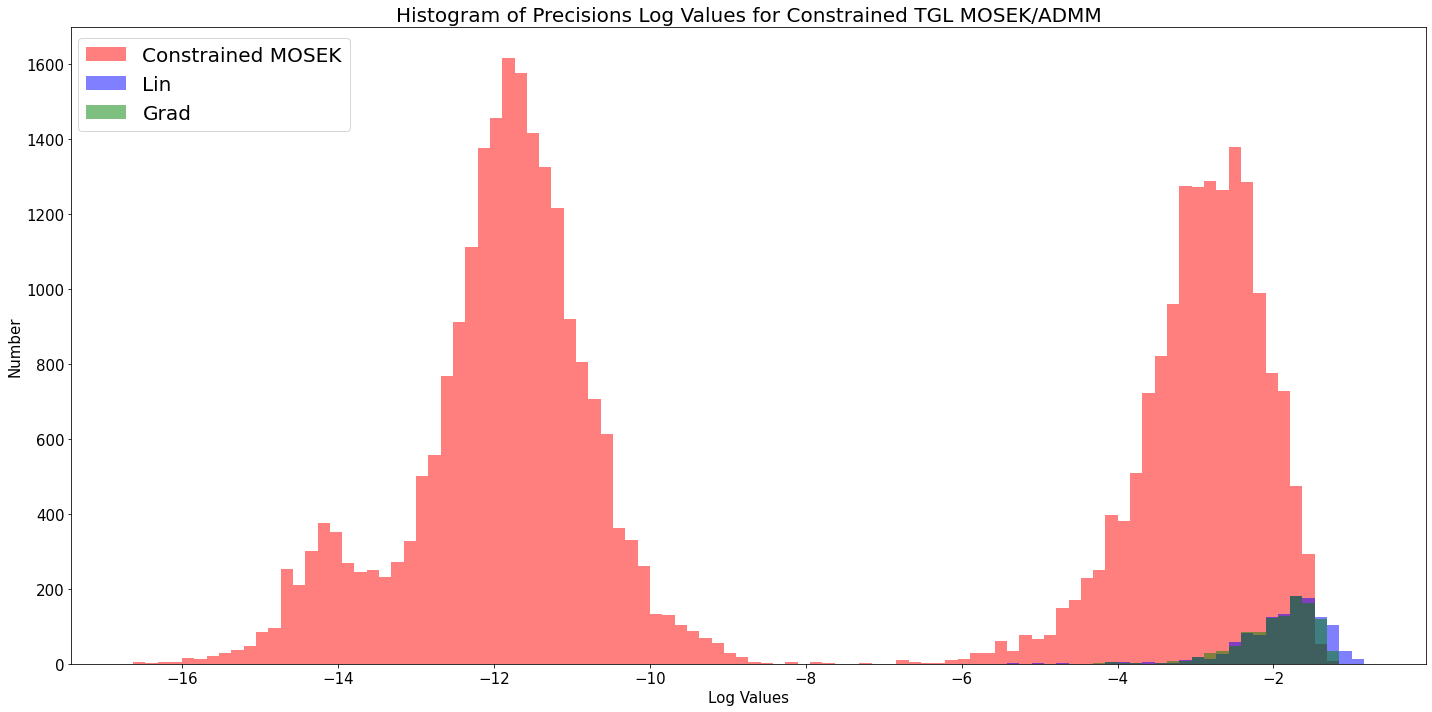

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgm"
color_index = 0

# ensure that the bins are the same for proper alignment
# bins = np.histogram(
#             np.hstack(
#                 (pre_cvx_no_diag.flatten(), pre_tpe_no_diag.flatten(), pre_g_no_diag.flatten())
#             ), bins=500)[1]
bins = np.histogram(
            np.hstack(
                (log_abs_pre_cvx_no_diag.flatten(), log_abs_pre_tpe_no_diag.flatten(), log_abs_pre_g_no_diag.flatten())
            ), bins=100)[1]

# ax.hist(pre_cvx_no_diag.flatten(), bins=bins, color='r', alpha=0.5, 
#             label=r'Constrained MOSEK')
# ax.hist(pre_tpe_no_diag.flatten(), bins=bins, color='b', alpha=0.5, 
#             label=r'Lin')
# ax.hist(pre_g_no_diag.flatten(), bins=bins, color='g', alpha=0.5, 
#             label=r'Grad')
ax.hist(log_abs_pre_cvx_no_diag.flatten(), bins=bins, color='r', alpha=0.5, 
            label=r'Constrained MOSEK')
ax.hist(log_abs_pre_tpe_no_diag.flatten(), bins=bins, color='b', alpha=0.5, 
            label=r'Lin')
ax.hist(log_abs_pre_g_no_diag.flatten(), bins=bins, color='g', alpha=0.5, 
            label=r'Grad')

fig.legend(fontsize=20, loc='upper left', bbox_to_anchor=(0.05, 0.455, 0.5, 0.5))
# plt.xlim([-0.01, 0.01])
ax.set_ylabel('Number', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Log Values', fontsize=15)
# ax.set_xticks([-1e-2, -1e-3, 0, 1e-3, 1e-2])
ax.set_title(r'Histogram of Precisions Log Values for Constrained TGL MOSEK/ADMM', fontsize=20)
plt.tight_layout()
plt.savefig('syn_' + str(weights[0]).lower() + '_' + str(max_iter) + '_hist.pdf')

In [ ]:
tgl_pre = {}

for i in np.arange(0, 1., 0.05):
    tgl = TimeGraphicalLasso(alpha=1., beta=i, mode='admm', rho=1, tol=1e-4,
                rtol=1e-4, psi='laplacian', max_iter=1000, verbose=False, assume_centered=False, 
                return_history=False, update_rho_options=None, compute_objective=True, 
                stop_at=None, stop_when=1e-4, suppress_warn_list=False, init='empirical')
    fit_score_, pre_ = tgl.fit_cov(X_cov).eval_cov_pre()   
    tgl_pre[1, i] = pre_
    tgl = TimeGraphicalLasso(alpha=i, beta=1, mode='admm', rho=1, tol=1e-4,
                rtol=1e-4, psi='laplacian', max_iter=1000, verbose=False, assume_centered=False, 
                return_history=False, update_rho_options=None, compute_objective=True, 
                stop_at=None, stop_when=1e-4, suppress_warn_list=False, init='empirical')
    fit_score_, pre_ = tgl.fit_cov(X_cov).eval_cov_pre()   
    tgl_pre[i, 1] = pre_

In [ ]:
tgl = TimeGraphicalLasso(alpha=1, beta=1, mode='admm', rho=1, tol=1e-4,
                rtol=1e-4, psi='laplacian', max_iter=1000, verbose=False, assume_centered=False, 
                return_history=False, update_rho_options=None, compute_objective=True, 
                stop_at=None, stop_when=1e-4, suppress_warn_list=False, init='empirical')
fit_score_, pre_ = tgl.fit_cov(X_cov).eval_cov_pre()   
tgl_pre[1, 1] = pre_
tgl_pre.keys()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgb"
color_index = 0
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

# ax.plot(range(X_cov.shape[-1]), emp_inv_score_g, color='k', label=r'Empirical Inverse')
ax.plot(range(X_cov.shape[-1]), baseline_score_g, color='k', label=r'Constraint')
for i in [1e-4]:
    mean_diff = np.mean(np.array(fit_score[i]) - baseline_score)
    max_diff = np.max(np.array(fit_score[i]) - baseline_score_g)
    ax.plot(range(X_cov.shape[-1]), fit_score[i], color='r', alpha=0.5, 
#     ax.plot(range(X_cov.shape[-1]), fit_score[i], color=colors[color_index], alpha=0.5, 
            label=r'MOSEK, Mean Diff = {:.3f}, Max Diff = {:.3f}'.format(mean_diff, max_diff))
    color_index += 1
# mean_diff = np.mean(np.array(fit_score_tp_thres[1e-4]) - baseline_score_g)
# # ax.plot(range(X_cov.shape[-1]), fit_score_tp, alpha=0.5, color='g',
# ax.plot(range(X_cov.shape[-1]), fit_score_tp_thres[1e-4], alpha=0.5, color='m',
#         label=r'Constrained ADMM Full, Mean Diff = {:.3f}'.format(mean_diff))
mean_diff = np.mean(np.array(fit_score_tpe_thres[1e-4]) - baseline_score_g)
max_diff = np.max(np.array(fit_score_tpe_thres[1e-4]) - baseline_score_g)
# ax.plot(range(X_cov.shape[-1]), fit_score_tp, alpha=0.5, color='g',
ax.plot(range(X_cov.shape[-1]), fit_score_tpe_thres[1e-4], alpha=0.5, color='b',
        label=r'Lin, Mean Diff = {:.3f}, Max Diff = {:.3f}'.format(mean_diff, max_diff))
mean_diff = np.mean(np.array(fit_score_g_thres[1e-4]) - baseline_score_g)
max_diff = np.max(np.array(fit_score_g_thres[1e-4]) - baseline_score_g)
# ax.plot(range(X_cov.shape[-1]), fit_score_tp, alpha=0.5, color='g',
ax.plot(range(X_cov.shape[-1]), fit_score_g_thres[1e-4], alpha=0.5, color='g',
        label=r'Grad, Mean Diff = {:.3f}, Max Diff = {:.3f}'.format(mean_diff, max_diff))

# mean_diff = np.mean(np.array(fit_score_) - res[1][1])
# ax.plot(range(X_cov.shape[-1]), fit_score_, color='y', label=r'Vanilla TGL, Mean Diff = {:.3f}'.format(mean_diff))

fig.legend(fontsize=20, loc='lower right', bbox_to_anchor=(0.495, 0.08, 0.5, 0.5))
ax.set_ylabel('Negative Log-Likelihood', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Time t', fontsize=25)
ax.set_title(r'NLL for Constraint and Constrained MOSEK/ADMM', fontsize=30)
plt.tight_layout()
plt.savefig('syn_'+ str(weights[0]).lower() + '_diff_like_converge_long.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgb"
color_index = 0

# ax.plot(range(X_cov.shape[-1]), [sum(sum(abs(emp_inv[k]) > 0)) for k in range(X_cov.shape[-1])], 
#         color='k', label=r'Empirical Inverse')
# for i in [min_pre_tp]:
for i in [1e-4]:
    supp = [sum(sum(abs(pre[i][t]) > 0)) for t in range(X_cov.shape[-1])]
    mean_supp = np.mean(supp)
    ax.plot(range(X_cov.shape[-1]), supp, color='r', alpha=0.5, 
#     ax.plot(range(X_cov.shape[-1]), supp, color=colors[color_index], alpha=0.5, 
            label=r'MOSEK, Mean Supp = {}'.format(mean_supp))
    color_index += 1
# supp = [sum(sum(abs(pre_grad[t]) > 0)) for t in range(X_cov.shape[-1])]
# ax.plot(range(X_cov.shape[-1]), supp, color='m', alpha=0.5,
#         label=r'Constraint TGL ADMM Gradient, Mean Supp = {:.3f}'.format(np.mean(supp)))
# supp = [sum(sum(abs(pre_tp_thres[1e-4][t]) > 0)) for t in range(X_cov.shape[-1])]
# # supp = [sum(sum(abs(pre_tp[t]) > 0)) for t in range(X_cov.shape[-1])]
# ax.plot(range(X_cov.shape[-1]), supp, color='m', alpha=0.5,
#         label=r'Constrained ADMM Full, Mean Supp = {:.3f}'.format(np.mean(supp)))
supp = [sum(sum(abs(pre_tpe_thres[1e-4][t]) > 0)) for t in range(X_cov.shape[-1])]
# supp = [sum(sum(abs(pre_tp[t]) > 0)) for t in range(X_cov.shape[-1])]
ax.plot(range(X_cov.shape[-1]), supp, color='b', alpha=0.5,
        label=r'Lin, Mean Supp = {:.3f}'.format(np.mean(supp)))
supp = [sum(sum(abs(pre_g_thres[1e-4][t]) > 0)) for t in range(X_cov.shape[-1])]
# supp = [sum(sum(abs(pre_tp[t]) > 0)) for t in range(X_cov.shape[-1])]
ax.plot(range(X_cov.shape[-1]), supp, color='g', alpha=0.5,
        label=r'Grad, Mean Supp = {:.3f}'.format(np.mean(supp)))
supp = [sum(sum(abs(pre_thres[1e-4][t]) > 0)) for t in range(X_cov.shape[-1])]
ax.plot(range(X_cov.shape[-1]), [sum(sum(abs(pre_thres[1e-4][k]) > 0)) for k in range(X_cov.shape[-1])], 
        color='y', label=r'TGL, , Mean Supp = {:.3f}'.format(np.mean(supp)))

fig.legend(fontsize=20, loc='upper right', bbox_to_anchor=(0.495, 0.45, 0.5, 0.5))
ax.set_ylabel('Support', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Time t', fontsize=25)
ax.set_title(r'Support for Constrained MOSEK/ADMM and TGL', fontsize=30)
plt.tight_layout()
plt.savefig('syn_'+ str(weights[0]).lower() + '_diff_supp_converge_long.pdf')

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgb"
color_index = 0

# diff_emp = [norm(emp_inv[t] - emp_inv[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
# ax.plot(range(1, X_cov.shape[-1]), np.array(diff_emp), alpha=1, color='k', label=r'Empirical Inverse')
# for i in [min_pre_tp]:
for i in [1e-4]:
    diff = [norm(pre[i][t] - pre[i][t-1], 'fro') for t in range(1, X_cov.shape[-1])]
    mean_diff = np.mean(diff)
    ax.plot(range(1, X_cov.shape[-1]), diff, color='r', alpha=0.5, 
#     ax.plot(range(1, X_cov.shape[-1]), diff, color=colors[color_index], alpha=0.5, 
            label=r'MOSEK, Mean Diff = {:.3f}'.format(mean_diff))
    color_index += 1
# diff_grad = [norm(pre_grad[t] - pre_grad[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
# ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='m', alpha=0.5,
#         label=r'Constraint TGL ADMM Gradient, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
# diff_grad = [norm(pre_tp_thres[1e-4][t] - pre_tp_thres[1e-4][t-1], 'fro') for t in range(1, X_cov.shape[-1])]
# # diff_grad = [norm(pre_tp[t] - pre_tp[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
# ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='m', alpha=0.5,
#         label=r'Constraint ADMM Full, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
diff_grad = [norm(pre_tpe_thres[1e-4][t] - pre_tpe_thres[1e-4][t-1], 'fro') for t in range(1, X_cov.shape[-1])]
# diff_grad = [norm(pre_tp[t] - pre_tp[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='b', alpha=0.5,
        label=r'Lin, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
diff_grad = [norm(pre_g_thres[1e-4][t] - pre_g_thres[1e-4][t-1], 'fro') for t in range(1, X_cov.shape[-1])]
# diff_grad = [norm(pre_tp[t] - pre_tp[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='g', alpha=0.5,
        label=r'Grad, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
diff_fit_ = [norm(pre_thres[1e-4][t] - pre_thres[1e-4][t-1], 'fro') for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), np.array(diff_fit_), color='y', alpha=1, 
        label=r'TGL, Mean Diff = {:.3f}'.format(np.mean(diff_fit_)))

fig.legend(fontsize=20, loc='upper right', bbox_to_anchor=(0.495, 0.45, 0.5, 0.5))
ax.set_ylabel('Difference in Frobenius Norm', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Time t', fontsize=25)
ax.set_title(r'Difference in Frobenius Norm for Constrained MOSEK/ADMM and TGL', fontsize=30)
plt.tight_layout()
plt.savefig('syn_'+ str(weights[0]).lower() + '_diff_fro_converge_long.pdf')
# plt.savefig('diff_fro_{}_{}_scs.pdf'.format(dim_X, dim_fac))